In [1]:
#import modules
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# All imports you likely would need
## Models and modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

## Data Munging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

## Measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay # for newer versions of sklearn
from sklearn.metrics import plot_confusion_matrix  # for older versions of sklearn
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv("startup data.csv", index_col=0)
df.head()

,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
df.isnull().sum()

state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enter

In [4]:
# data wrangling
df = df.drop(['Unnamed: 6'], axis=1)
df = df.drop(['state_code.1'], axis=1)
df = df.drop(['object_id'], axis=1)
start = ['c:']
end = ['']
df['id'] = df['id'].replace(start, end, regex=True)
df.avg_participants = df.avg_participants.round(4)
df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(0)
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(0)

In [5]:
# determine age of startup
df['closed_at'] = pd.to_datetime(df['closed_at'])
df['founded_at'] = pd.to_datetime(df['founded_at'])

# too many NaN in age
df["age"] = (df["closed_at"]-df["founded_at"])
df["age"]=round(df.age/np.timedelta64(1,'Y'))
#df['age'].fillna(0)

In [6]:
# variable modification
df['status'] = df.status.map({'acquired':1, 'closed':0})
df['status'].astype(int)

#has rounds of funding
df['has_rounds'] = np.where((df['has_roundA'] == 1) | (df['has_roundB'] == 1) | (df['has_roundC'] == 1) | (df['has_roundD'] == 1), 1, 0)

#has investor
df['has_investor'] = np.where((df['has_VC'] == 1) | (df['has_angel'] == 1), 1, 0)

In [7]:
# probability analysis
""" goal: narrow down a few factors that show statistically significant results
--> later, we will use them as parameters for machine learning model"""

' goal: narrow down a few factors that show statistically significant results\n--> later, we will use them as parameters for machine learning model'

In [8]:
# Do startups with more funding tend to be more successful?

fund_avg = np.mean(df['funding_total_usd'])
df_high_funding = df[df['funding_total_usd'] > fund_avg]
df_low_funding = df[df['funding_total_usd'] <= fund_avg]
p_val = stats.ttest_ind(np.array(df_high_funding["status"]), np.array(df_low_funding["status"]))[1]

print('p-value:', p_val)
print('.shape of my subset(s):')
print(df_high_funding.shape)
print(df_low_funding.shape)

p-value: 0.0006484482419631345
.shape of my subset(s):
(218, 48)
(705, 48)


H0: The average number of successful startups is the **same** for companies with higher than the average funding and lower than the average funding.

H1: The average number of successful startups is the **not the same** for companies with higher than the average funding and lower than the average funding.

This code splits the data into two subsets using the threshold of `Funding Total USD == Average Funding`. Then it performs a two-sided t-test by calling `stats.ttest_ind` on the `status` column of these two subsets.

The p-value for my hypothesis test is 0.00065. 

Using a cutoff of 0.05, this is enough evidence to reject the Null Hypothesis.

I used the `stats.ttest_ind` function to conduct my hypothesis test because there are two subsets and they don't overlap.

In [9]:
# Do startups with more milestones tend to be more successful?

ms_avg = np.mean(df['milestones'])
df_high = df[df['milestones'] > ms_avg]
df_low = df[df['milestones'] <= ms_avg]
p_val = stats.ttest_ind(np.array(df_high["status"]), np.array(df_low["status"]))[1]

print('p-value:', p_val)
print('.shape of my subset(s):')
print(df_high.shape)
print(df_low.shape)

p-value: 2.780028274247565e-20
.shape of my subset(s):
(521, 48)
(402, 48)


In [10]:
# Do startups with more relationships tend to be more successful?

relation_avg = np.mean(df['relationships'])
df_r_high = df[df['relationships'] > relation_avg]
df_r_low = df[df['relationships'] <= relation_avg]
p_val = stats.ttest_ind(np.array(df_r_high["status"]), np.array(df_r_low["status"]))[1]

print('p-value:', p_val)
print('.shape of my subset(s):')
print(df_r_high.shape)
print(df_r_low.shape)

p-value: 3.2273151282765555e-26
.shape of my subset(s):
(340, 48)
(583, 48)


In [11]:
# Do older startups tend to be more successful?

age_avg = np.mean(df['age'])
df_old = df[df['age'] > age_avg]
df_young = df[df['age'] <= age_avg]
p_val = stats.ttest_ind(np.array(df_old["status"]), np.array(df_young["status"]))[1]

print('p-value:', p_val)
print('.shape of my subset(s):')
print(df_old.shape)
print(df_young.shape)

p-value: 0.9260999527470455
.shape of my subset(s):
(154, 48)
(181, 48)


In [12]:
# Funding by most successful # of startup locations

df_ny = df[df['state_code']=='NY']
n1 = df_ny.shape[0]
interval1 = stats.norm.interval(
    0.95, df_ny['funding_total_usd'].mean(),
    df_ny['funding_total_usd'].std()/np.sqrt(n1))

df_ca = df[df['state_code']=='CA']
n2 = df_ca.shape[0]
interval2 = stats.norm.interval(
    0.95, df_ca['funding_total_usd'].mean(),
    df_ca['funding_total_usd'].std()/np.sqrt(n2))

df_ma = df[df['state_code']=='MA']
n3 = df_ma.shape[0]
interval3 = stats.norm.interval(
    0.95, df_ma['funding_total_usd'].mean(),
    df_ma['funding_total_usd'].std()/np.sqrt(n3))

print(f"N1: {n1}, N2: {n2}, N3: {n3}")
print('Funding in NY:', interval1)
print('Funding in CA:', interval2)
print('Funding in MA:', interval3)

N1: 106, N2: 488, N3: 83
Funding in NY: (8792587.862359444, 16276237.307451876)
Funding in CA: (18144610.940789524, 22866886.546915393)
Funding in MA: (17040942.816018447, 26964166.485186376)


In [13]:
# Do more popular startups have higher funding amounts than less popular startups?

df_tech = df[df['category_code']=='software']
n1 = df_tech.shape[0]
interval1 = stats.norm.interval(
    0.95, df_tech['funding_total_usd'].mean(),
    df_tech['funding_total_usd'].std()/np.sqrt(n1))

df_transport = df[df['category_code']=='transportation']
n2 = df_transport.shape[0]
interval2 = stats.norm.interval(
    0.95, df_transport['funding_total_usd'].mean(),
    df_transport['funding_total_usd'].std()/np.sqrt(n2))

print(f"N1: {n1}, N2: {n2}")
print('Funding for tech', interval1)
print('Funding for transportation:', interval2)


N1: 153, N2: 2
Funding for tech (13772561.597359316, 20967292.84708513)
Funding for transportation: (57682580.97000505, 70021789.02999495)


In [14]:
# Do startups in California or New York tend to be more successful?

nAll = len(df)

nSuccess = sum(df['status'] == 1)
isSuccess = df[df['status'] == 1]

nCA = sum(df['state_code'] == 'CA')
hasCA = df[df['state_code'] == 'CA']

nNY = sum(df['state_code'] == 'NY')
hasNY = df[df['state_code'] == 'NY']

prob_a = nSuccess/nAll
prob_b = nCA/nAll
prob_c = nNY/nAll

prob_a_given_b_data = sum(hasCA['status'] == 1)/nCA
prob_b_given_a_data = sum(isSuccess['state_code'] == 'CA')/nSuccess
prob_a_given_b_bayes = (prob_b_given_a_data*prob_a)/prob_b
prob_b_given_a_bayes = (prob_a_given_b_data*prob_b)/prob_a
print("Success given CA:", prob_a_given_b_bayes)
print("CA given success:", prob_b_given_a_bayes)

prob_a_given_c_data = sum(hasNY['status'] == 1)/nNY
prob_c_given_a_data = sum(isSuccess['state_code'] == 'NY')/nSuccess
prob_a_given_c_bayes = (prob_c_given_a_data*prob_a)/prob_c
prob_c_given_a_bayes = (prob_a_given_c_data*prob_c)/prob_a
print("Success given NY:", prob_a_given_c_bayes)
print("NY given success:", prob_c_given_a_bayes)

Success given CA: 0.680327868852459
CA given success: 0.5561139028475712
Success given NY: 0.7264150943396227
NY given success: 0.12897822445561138


In [15]:
# visualizations
""" goal: explore startup success by different key factors:
--> location
--> funding amount
--> industry
--> age"""

' goal: explore startup success by different key factors:\n--> location\n--> funding amount\n--> industry\n--> age'

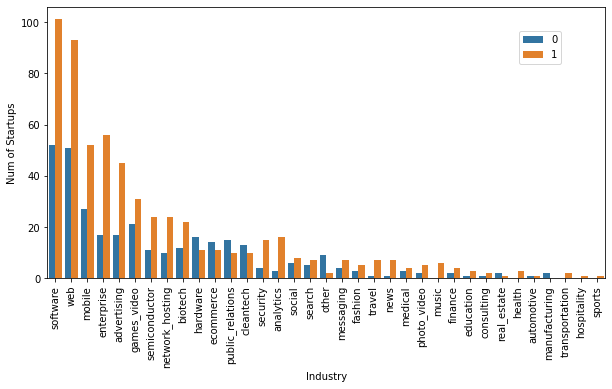

In [16]:
# Which industries seem to have the most successful startups?
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="category_code", hue="status", data=df,
              order=df.category_code.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel="Industry", ylabel="Num of Startups")
plt.legend(bbox_to_anchor=(0.93, 0.93))

In [17]:
# Which industries had a startup that received the most funding?
cat_funding_amt = df.groupby(['category_code','funding_total_usd']).size().rename('total_startups').reset_index()
cat_funding_amt = cat_funding_amt[cat_funding_amt.groupby('category_code')['total_startups'].transform(max) == cat_funding_amt['total_startups']]
cat_funding_amt = cat_funding_amt.sort_values('funding_total_usd', ascending=False)
cat_funding_amt.head(10)

,category_code,funding_total_usd,total_startups
459,other,135826373,1
237,finance,89500000,1
71,analytics,74000000,1
458,other,72000000,1
686,transportation,67000000,1
685,transportation,60704370,1
466,photo_video,57500000,1
236,finance,55350000,1
95,biotech,55000000,2
70,analytics,53000000,1


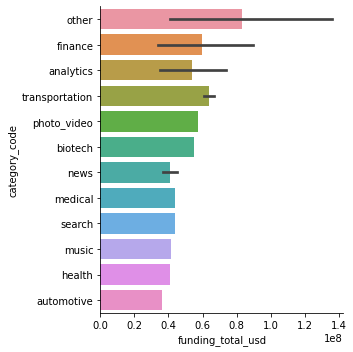

In [18]:
#Visualization of funding by industry
cat_funding_amt = cat_funding_amt.sort_values(by='funding_total_usd', ascending=False)
sns.catplot(data=cat_funding_amt[:20], y="category_code", x="funding_total_usd", kind="bar")

In [19]:
# Which industry startups are successful in which locations?
success_data = df[df['status']==1]
loc_industry_success = success_data.groupby(['state_code','category_code']).size().rename('total_startups').reset_index()
loc_industry_success = loc_industry_success[loc_industry_success.groupby('state_code')['total_startups'].transform(max) == loc_industry_success['total_startups']]
loc_industry_success = loc_industry_success.sort_values('total_startups', ascending=False)
loc_industry_success.head(10)

,state_code,category_code,total_startups
31,CA,web,55
72,MA,software,16
111,NY,web,15
144,WA,mobile,5
128,TX,enterprise,4
136,TX,web,4
51,IL,software,4
37,CO,software,4
44,GA,enterprise,2
138,VA,mobile,2


In [20]:
# DataFrame with the age of startups grouped by each combination of state code and status
pivot_table = df.pivot_table("id", index="state_code", columns="status", aggfunc="count")
#pivot_table.sort_values(by=['status'], ascending=False)
pivot_table

status,0,1
state_code,,
AR,1.0,NaN
AZ,1.0,1.0
CA,156.0,332.0
CO,5.0,14.0
CT,4.0,NaN
DC,2.0,2.0
FL,4.0,2.0
GA,5.0,6.0
ID,1.0,NaN


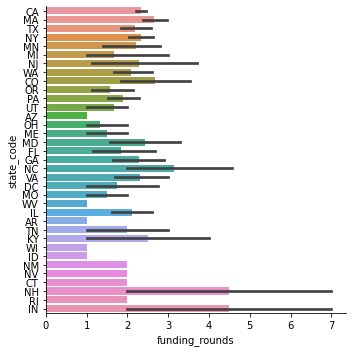

In [21]:
# Which locations had the most rounds of funding?
rounds_df = df.sort_values(by=["funding_rounds"], ascending=True)
sns.catplot(data=rounds_df, y="state_code", x="funding_rounds", kind="bar")

In [22]:
# Locations of the topmost funded startups
loc_funding_amt = df.groupby(['state_code','funding_total_usd']).size().rename('total_startups').reset_index()
loc_funding_amt = loc_funding_amt[loc_funding_amt.groupby('state_code')['total_startups'].transform(max) == loc_funding_amt['total_startups']]
loc_funding_amt = loc_funding_amt.sort_values('funding_total_usd', ascending=False)
loc_funding_amt.head(10)

,state_code,funding_total_usd,total_startups
332,CO,510000000,1
378,IN,238209999,1
479,NC,162264126,1
336,CT,125000000,1
460,MD,100000000,1
488,NJ,78500000,1
610,PA,75000000,1
609,PA,69900000,1
331,CO,68400000,1
357,GA,60704370,1


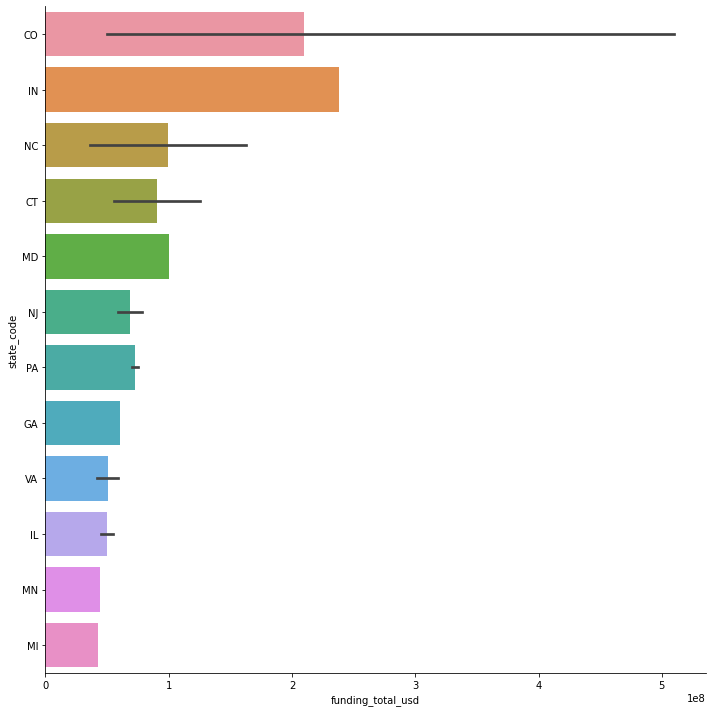

In [23]:
# Visualize locations with topmost funding
loca_funding_amt = loc_funding_amt.sort_values(by='funding_total_usd', ascending=False)
sns.catplot(data=loc_funding_amt[:20], y="state_code", x="funding_total_usd", kind="bar", height=10)

<AxesSubplot:xlabel='has_investor', ylabel='avg_participants'>

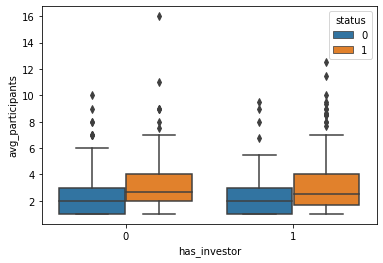

In [24]:
# Compare the success of startups based on the number of participants they have 
# and if they received funding
sns.boxplot(x = "has_investor", y = "avg_participants", 
            data = df, hue = "status")

<AxesSubplot:xlabel='milestones', ylabel='Count'>

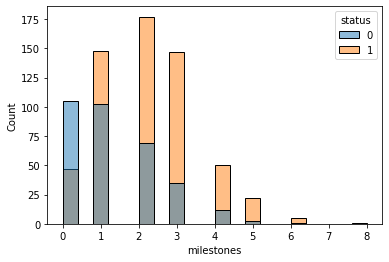

In [25]:
# How many milestones do successful startups tend to have?
sns.histplot(x = "milestones", data = df, hue="status")

<AxesSubplot:xlabel='age', ylabel='relationships'>

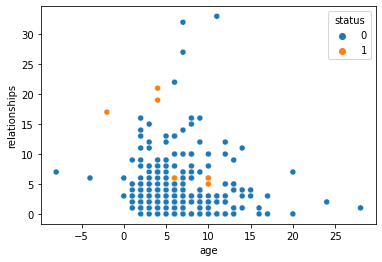

In [26]:
# How does age relate to the number of relationships?
# Is there a certain combination that tends to have more successful startups?
sns.scatterplot(data=df, x='age', y='relationships', hue='status')

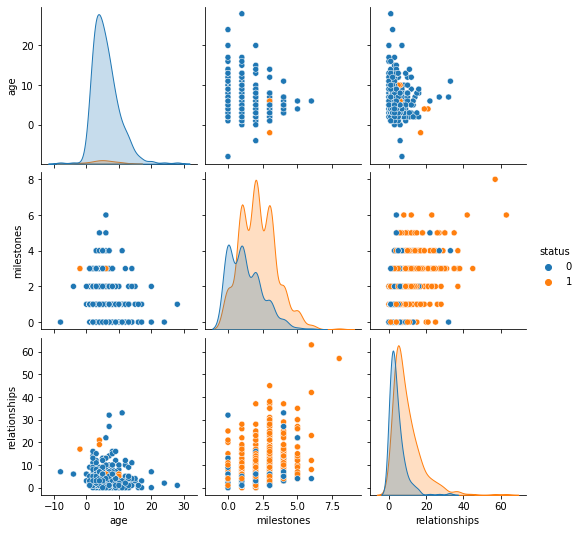

In [27]:
# Pair plot - find which combinations of age, milestones, and relationships seem to have the most successful startups
pair_data = df[['age','milestones','relationships', 'status']]
sns.pairplot(pair_data, hue="status")

<AxesSubplot:>

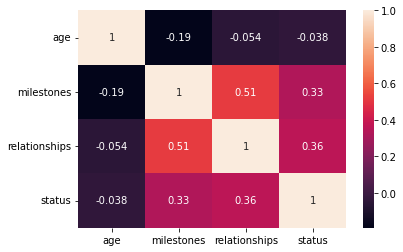

In [28]:
# Check if the pair plot variables have correlations?
heatmap_data = df[['age', 'milestones','relationships', 'status']]
sns.heatmap(heatmap_data.corr(), annot=True)

<AxesSubplot:>

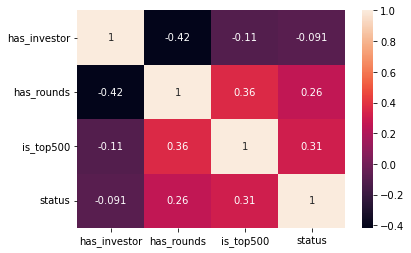

In [29]:
# Check if binary variables are correlated to success in any way
heatmap_data2 = df[['has_investor', 'has_rounds','is_top500','status']]
sns.heatmap(heatmap_data2.corr(), annot=True)

In [30]:
# machine learning model - 71% accurate
""" goal: use top 3-4 factors from prob & visualization analysis
--> create a machine learning model to predict startup success"""

' goal: use top 3-4 factors from prob & visualization analysis\n--> create a machine learning model to predict startup success'

best n: 9


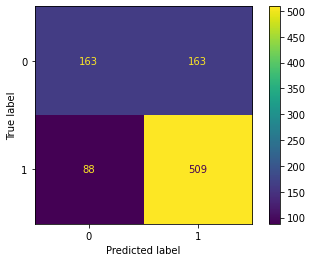

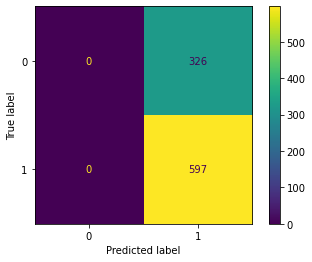

In [31]:
df_ml = df[['status', 'funding_total_usd', 'milestones', 'relationships', 'category_code']]
col_target = 'status'

target = df_ml[col_target].values
categorical = OneHotEncoder().fit_transform(df_ml[['category_code']].values).toarray()
data = np.append(categorical, df_ml[['funding_total_usd', 'milestones', 'relationships']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)


In [32]:
print(df_ml.shape)
print('>=300 rows?', df_ml.shape[0] >= 300)
print('Categories:')
print(df_ml[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 5)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.7081081081081081
Accuracy Baseline:  0.6468039003250271


best n: 9


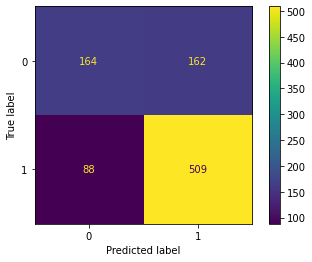

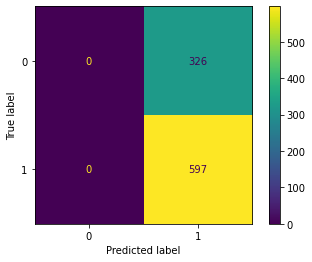

In [36]:
#ML #2: LOCATION INSTEAD OF INDUSTRY

df_ml2 = df[['status', 'funding_total_usd', 'milestones', 'relationships', 'state_code']]
col_target = 'status'

target = df_ml2[col_target].values
categorical = OneHotEncoder().fit_transform(df_ml2[['state_code']].values).toarray()
data = np.append(categorical, df_ml2[['funding_total_usd', 'milestones', 'relationships']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)


In [37]:
print(df_ml2.shape)
print('>=300 rows?', df_ml2.shape[0] >= 300)
print('Categories:')
print(df_ml2[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 5)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.7081081081081081
Accuracy Baseline:  0.6468039003250271


best n: 9


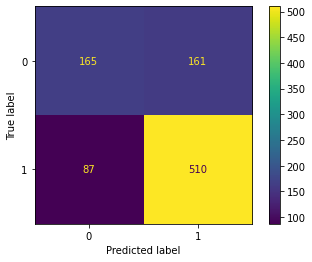

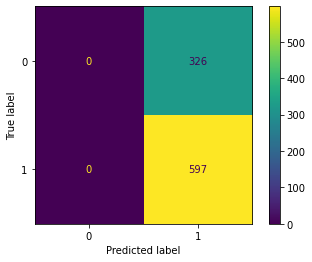

In [40]:
# ML3: NO STATE / INDUSTRY

df_ml3 = df[['status', 'funding_total_usd', 'milestones', 'relationships']]
col_target = 'status'

target = df_ml3[col_target].values
data = df_ml3

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)

In [41]:
print(df_ml3.shape)
print('>=300 rows?', df_ml3.shape[0] >= 300)
print('Categories:')
print(df_ml3[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 4)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.7081081081081081
Accuracy Baseline:  0.6468039003250271


best n: 3


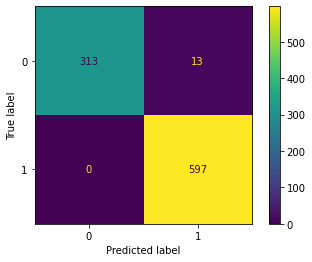

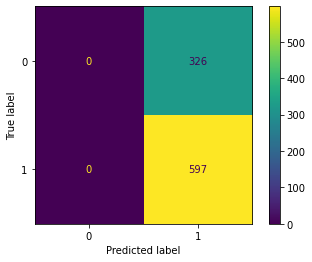

In [42]:
# ML4: NO FUNDING
df_ml4 = df[['status', 'milestones', 'relationships']]
col_target = 'status'

target = df_ml4[col_target].values
data = df_ml4

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)

In [43]:
print(df_ml4.shape)
print('>=300 rows?', df_ml4.shape[0] >= 300)
print('Categories:')
print(df_ml4[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 3)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.9783783783783784
Accuracy Baseline:  0.6468039003250271


best n: 9


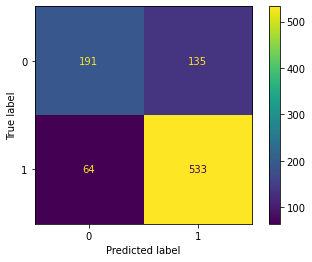

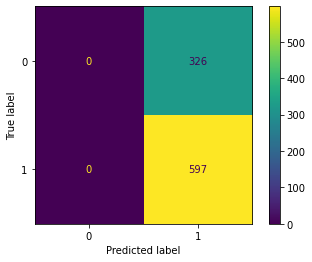

In [46]:
# ML5: no funding, but use industry

df_ml5 = df[['status', 'milestones', 'relationships', 'category_code']]
col_target = 'status'

target = df_ml5[col_target].values
categorical = OneHotEncoder().fit_transform(df_ml5[['category_code']].values).toarray()
data = np.append(categorical, df_ml5[['milestones', 'relationships']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)

In [47]:
print(df_ml5.shape)
print('>=300 rows?', df_ml5.shape[0] >= 300)
print('Categories:')
print(df_ml5[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 4)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.7567567567567568
Accuracy Baseline:  0.6468039003250271


best n: 18


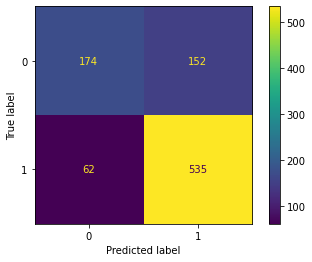

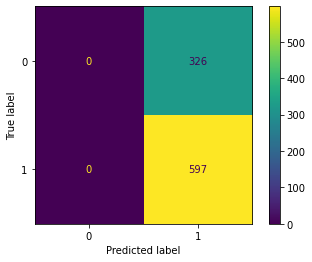

In [48]:
# ML5: no funding, but use state

df_ml6 = df[['status', 'milestones', 'relationships', 'state_code']]
col_target = 'status'

target = df_ml6[col_target].values
categorical = OneHotEncoder().fit_transform(df_ml6[['state_code']].values).toarray()
data = np.append(categorical, df_ml6[['milestones', 'relationships']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)

In [49]:
print(df_ml6.shape)
print('>=300 rows?', df_ml6.shape[0] >= 300)
print('Categories:')
print(df_ml6[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 4)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.8162162162162162
Accuracy Baseline:  0.6468039003250271


In [33]:
# linear regression model - not a good fit

df_lr = df[['funding_total_usd', 'milestones', 'relationships']].values
target = df['status'].values

linear_model = LinearRegression()
linear_model.fit(X=data, y=target)
df["predicted_status"] = linear_model.predict(data)
predicted = linear_model.predict(data)

mse = mean_squared_error(df["status"], df["predicted_status"]) # float: MSE of your model
r2 = r2_score(df["status"], df["predicted_status"] ) # float: R^2 score of your model

avg = np.mean(df['status'])
baseline = np.full(predicted.shape, avg)
b_mse = mean_squared_error(target, baseline) # float: MSE of the baseline 
b_r2 = r2_score(target, baseline) # float: R^2 score of the baseline

print("Model MSE:", mse, "r^2:", r2)
print("Baseline MSE:", b_mse, "r^2:", b_r2)

Model MSE: 0.18081438997112106 r^2: 0.20851176930816062
Baseline MSE: 0.22844861484935955 r^2: 0.0


After trying combinations of parameters, we get a much higher accuracy by not including funding and only focusing on milestones and relationships. --> Odd conclusion

We can try to include variations with state and industry to see if they affect model accuracy as well.

In [34]:
# logistic regression

# df_lr2 = df[['funding_total_usd', 'milestones', 'relationships']].values
# target = df['status'].values
# train_data, test_data, train_target, test_target = train_test_split(
#     data, target, test_size=0.2, random_state=999)

# logistic_model = LogisticRegression(max_iter=1000)
# logistic_model.fit(X=train_data, y=train_target)
# predicted_status = logistic_model.predict(test_data)
# model_accuracy = accuracy_score(test_target.values, predicted_status)
# print("accuracy:", model_accuracy)
# ConfusionMatrixDisplay.from_estimator(estimator=logistic_model, X=test_data, y=test_target.values)
# plt.grid(False)
